In [1]:
include("../math405.jl")

 Activating environment at `~/Documents/UBC/Math/Math 405/math405_2020W/Project.toml`


# Introduction to the Thomas Algorithm

In class, we showed how to calculate the solution to linear systems using Gaussian Elimination and LU Decomposition.

In the general case we studied we had $ A x = b $ where 
$$
    A = 
    \begin{pmatrix}
        A_{11} & A_{12} &  \cdots & A_{1N}  \\ 
        A_{21} & A_{22} &  \cdots & A_{2N}  \\ 
          \vdots & \vdots &        & \vdots \\ 
        A_{N1} & A_{N2} &  \cdots & A_{NN}  \\ 
    \end{pmatrix}
$$
***

#### Cost analysis of LU decomposition

In class we showed that a backsubstitution algorthm will be $\mathcal{O}(N^2)$ so all that is left is to see how expensive our Gaussian elimination will be. For simplicity, assume $+,-,\times,\div$ are all the same cost, 1 flop.

For each element in the first column $A_{21}$, $A_{31}$, ... , $A_{N1}$ we will need to do $N$ additions (one for each element of the given row). We will need to repeat this for each column, but each time, our starting point in the column and number of additions will each decrease by one.

$$
    \sum_{i=1}^{N} \sum_{j=i}^{N} \sum_{k=i}^{N+1} \mathcal{O}(1)
    \implies \sum_{i=1}^{N} (N - i)(N + 1 - i)
$$
If we let $j = N - i$, the sum simply reverses and we have 
$$
    \sum_{j=1}^{N} j(j+1) \implies \sum_{j=1}^{N} j^2 + \sum_{j=1}^{N} j
$$
These are a known sums, we end up with 
$$
   \frac{N^3}{3} + \frac{N^2}{2} + \frac{N}{6} + \frac{N(N+1)}{2} 
$$
Which is $\mathcal{O}(N^3)$, therefore Gaussian elimination dominates the time complexity.

**Summary: GE and LU decomposition are great for the general case, but quite slow.**

*Question: Are there are some special cases where we can do better?*

***

#### Tridiagonal systems
Noe that we have shown the cost of using LU decomposition to solve a problem, let's consider a problem where we should be able to do better. 

Consider the case of a initial value problem with $x \in (0, 1)$
$$
     \dot y = \frac{\partial^2 y}{\partial x^2}
$$
with initial conditions $y(x, 0) = g(x)$. 

*Note that I am using the notation* $\dot y = dy/dt$, $\ddot y = d^2y/dt^2$

Using finite differences, we can show that for our function $y(x, t)$
$$
    \frac{\partial^2 y}{\partial x^2} \approx \frac{y(x + h_x, t) - 2y(x, t) + f(x - h_x, t)}{h_x^2}
$$
With step size (in $x$) $h_x$ - this can be thought of as nodal spacing. *Please see (1) or (3) for explicit calculations of this.*

<!-- Include calculation in comments -->

What about in the time domain? Well we can compute a forward difference like so
$$
    \dot y \approx \frac{y(x, t + h_t) - y(x, t)}{h_t}
$$
So we get 
$$
    y(x, t + h_t) = y(x, t) + \frac{h_t}{h_x^2}\cdot[(y(x + h_x, t) - 2y(x, t) + f(x - h_x, t)]
$$
Now we have a way to calculate but we will run into issues if the following does not hold.
$$
    h_t \leq \frac{h_x^2}{2} 
$$
*See (3) or (4) for a proof of explicitly why this happens*

Despite not going into depth about why this happens, its maybe not so hard to see that there will be a problem coming from the fact that $\partial^2 y/\partial x^2$ is not calculated at $t + h_t$ (since we don't know the values that we would need to solve it).

We can introduce the Crank-Nicolson scheme and without going into too much detail this will mean that we average on the contribution to the second spatial derivative from timestep $t + h_t$.
$$
     -\frac{h_t}{2h_x^2}\cdot y(x + h_x, t + h_t) + (1 + \frac{h_t}{h_x^2})\cdot y(x, t + h_t) -\frac{h_t}{2h_x^2}\cdot y(x - h_x, t + h_t) \\= -\frac{h_t}{2h_x^2}\cdot y(x + h_x, t) + (1 + \frac{h_t}{h_x^2})\cdot y(x, t) -\frac{h_t}{2h_x^2}\cdot y(x - h_x, t)
$$
The point of all this is we must solve a tridiagonal linear system like the one below many times (at each timestep) if we want to be able to do better than the initial approach.

$$
    A = 
    \begin{pmatrix}
        A_{11} & A_{12} & 0         & 0         & \cdots     & 0     \\ 
        A_{12} & A_{22} & A_{23}    & 0         & \cdots     & 0     \\ 
        \vdots & \vdots & \vdots    & \vdots    & \vdots             \\ 
        0      & \cdots & 0         & 0         & A_{N,N-1}  & A_{NN}\\ 
    \end{pmatrix}
$$

For the Crank-Nicolson scheme, elements in each row will be, respectively,

$$
    -\frac{h_t}{2h_x^2}, (1 + \frac{h_t}{h_x^2}), -\frac{h_t}{2h_x^2}
$$

i.e. the same for the first and last elements.

<!-- The off diagonal elements are contributions from neighboring nodes. Note that it is common to use dummy/ghost points to enforce boundary conditions i.e. drop $A_{12}$ and $A_{N,N-1}$ terms. -->

But, if we try to use LU decomposition we will end up with $\mathcal{O}(N^3)$ for each time iteration, surely we can do better than this -- we have so many fewer eliminations to do!
***

## How does the Thomas algorithm actually work?

Consider an tridiagonal matrix system

$$
    A\mathbf{x} = \mathbf{d}\implies\begin{bmatrix}
        b_1 & c_1 & 0 & 0 & \cdots & 0 & d_1 \\
        a_1 & b_2 & c_2 & 0 & \cdots & 0 & d_2 \\
        0 & a_2 & b_3 & c_3 & \cdots & 0 & d_3 \\
        \vdots & & \ddots & \ddots & \ddots & & \vdots \\
        0 & & & a_{n-2} & b_{n-1} & c_{n-1} & d_{n-1} \\
        0 & & & 0 & a_{n-1} & b_n & d_n
    \end{bmatrix}
$$

First, we divide the first row by $b_1$

$$
    \begin{bmatrix}
        1 & c_1' & 0 & 0 & \cdots & 0 & d_1' \\
        a_1 & b_2 & c_2 & 0 & \cdots & 0 & d_2 \\
        0 & a_2 & b_3 & c_3 & \cdots & 0 & d_3 \\
        \vdots & & \ddots & \ddots & \ddots & & \vdots \\
        0 & & & a_{n-2} & b_{n-1} & c_{n-1} & d_{n-1} \\
        0 & & & 0 & a_{n-1} & b_n & d_n
    \end{bmatrix}
$$

where $c_1' = \frac{c_1}{b_1}$ and $d_1' = \frac{d_1}{b_1}$. Then let us multiply the first row by $-a_1$ and add it to the second row

$$
    \begin{bmatrix}
        1 & c_1' & 0 & 0 & \cdots & 0 & d_1' \\
        0 & b_2' & c_2 & 0 & \cdots & 0 & d_2' \\
        0 & a_2 & b_3 & c_3 & \cdots & 0 & d_3 \\
        \vdots & & \ddots & \ddots & \ddots & & \vdots \\
        0 & & & a_{n-2} & b_{n-1} & c_{n-1} & d_{n-1} \\
        0 & & & 0 & a_{n-1} & b_n & d_n
    \end{bmatrix}
$$

where $b_2' = b_2 - a_1c_1'$ and $d_2' = d_2 - a_1d_1'$. Repeating the process, we divide the second row by $b_2'$

$$
    \begin{bmatrix}
        1 & c_1' & 0 & 0 & \cdots & 0 & d_1' \\
        0 & 1 & c_2' & 0 & \cdots & 0 & d_2'' \\
        0 & a_2 & b_3 & c_3 & \cdots & 0 & d_3 \\
        \vdots & & \ddots & \ddots & \ddots & & \vdots \\
        0 & & & a_{n-2} & b_{n-1} & c_{n-1} & d_{n-1} \\
        0 & & & 0 & a_{n-1} & b_n & d_n
    \end{bmatrix}
$$

where 

$$
    \begin{align*}
        c_2' = \frac{c_2}{b_2'} = \frac{c_2}{b_2-a_1c_1'} && d_2'' = \frac{d_2'}{b_2'} = \frac{d_2 - a_1d_1'}{b_2 - a_1c_1'}
    \end{align*}
$$

Continuing on, we multiply the second row by $-a_2$ and add it to the third row

$$
    \begin{bmatrix}
        1 & c_1' & 0 & 0 & \cdots & 0 & d_1' \\
        0 & 1 & c_2' & 0 & \cdots & 0 & d_2'' \\
        0 & 0 & b_3' & c_3 & \cdots & 0 & d_3' \\
        \vdots & & \ddots & \ddots & \ddots & & \vdots \\
        0 & & & a_{n-2} & b_{n-1} & c_{n-1} & d_{n-1} \\
        0 & & & 0 & a_{n-1} & b_n & d_n
    \end{bmatrix}
$$

where $b_3' = b_3 - a_2c_2'$ and $d_3' = d_3 - a_2d_2''$. Again, we divide the third row by $b_3'$

$$
    \begin{bmatrix}
        1 & c_1' & 0 & 0 & \cdots & 0 & d_1' \\
        0 & 1 & c_2' & 0 & \cdots & 0 & d_2'' \\
        0 & 0 & 1 & c_3' & \cdots & 0 & d_3'' \\
        \vdots & & \ddots & \ddots & \ddots & & \vdots \\
        0 & & & a_{n-2} & b_{n-1} & c_{n-1} & d_{n-1} \\
        0 & & & 0 & a_{n-1} & b_n & d_n
    \end{bmatrix}
$$

where

$$
    \begin{align*}
        c_3' = \frac{c_3}{b_3'} = \frac{c_3}{b_3-a_2c_2'} && d_3'' = \frac{d_3'}{b_3'} = \frac{d_3 - a_2d_2'}{b_3 - a_2c_2'}
    \end{align*}
$$

Repeating the Gaussian elimination row by row, we end up with a upper triangular matrix (upper bidiagonal matrix)

\[\begin{bmatrix}
    1 & c_1' & 0 & 0 & \cdots & 0 & d_1' \\
    0 & 1 & c_2' & 0 & \cdots & 0 & d_2'' \\
    0 & 0 & 1 & c_3' & \cdots & 0 & d_3'' \\
    \vdots & & \ddots & \ddots & \ddots & & \vdots \\
    0 & & & 0 & 1 & c_{n-1}' & d_{n-1}'' \\
    0 & & & 0 & 0 & 1 & d_n''
\end{bmatrix}\]

Now, using backward substitution, the solution is

$$
    \begin{gather*}
        x_n = d_n'' \\
        x_{n-1} = d_{n-1}'' - c_{n-1}'x_n \\
        \vdots \\
        x_1 = d_1' - c_1'x_2
    \end{gather*}
$$
Here is the pesudocode for the algorithm. Note that we have the vectors

$$
    \begin{align*}
        a = \begin{bmatrix} a_1 & a_2 & \cdots & a_{n-1} \end{bmatrix}^T &&
        b = \begin{bmatrix} b_1 & b_2 & \cdots & b_n \end{bmatrix}^T \\
        c = \begin{bmatrix} c_1 & c_2 & \cdots & c_{n-1} \end{bmatrix}^T &&
        d = \begin{bmatrix} d_1 & d_2 & \cdots & d_n \end{bmatrix}^T
    \end{align*}
$$

```
# divide the first row by the main diagonal element
c[1] = c[1]/b[1]
d[1] = d[1]/b[1]

# Perform Gaussian elimination: the tridiagonal matrix becomes the upper bidiagonal matrix.
for i = 2:n-1
    c[i] = c[i]/(b[i] - a[i]*c[i-1])
    d[i] = (d[i] - a[i-1]*d[i-1])/(b[i] - a[i-1]*c[i-1])
end

# Compute d[n]
d[n] = (d[n] - a[n-1]*d[n-1])/(b[n] - a[n-1]*c[n-1])

# The first solution.
x[n] = d[n]

# Perform backward substitution, the solution is obtained.
for i = n-1:1
    x[i] = d[i] - c[i]*x[i+1]
end
```

From the algorithm, we are always dividing by \(b_n - a_{n-1}c'_n\) and, hence, division by zero can occur which means numerical stability is not always guaranteed. Hence, we have the sufficient condition: if \(A\) is diagonally dominant, the Thomas algorithm never encounters division by zero. A square matrix is diagonally dominant if the absolute value of each diagonal element is greater than the sum of the absolute values of other elements in the row.
\newline

A tridiagonal matrix is sparse which means the matrix contains lots of zeroes!  The Thomas algorithm takes advantage and we only need to do simple calculations.
Consider the 10 by 10 tridiagonal matrix
                                                        
$$
    \begin{bmatrix}
        b_1 & c_1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        a_1 & b_2 & c_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & a_2 & b_3 & c_3 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & a_3 & b_4 & c_4 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & a_4 & b_5 & c_5 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & a_5 & b_6 & c_6 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & a_6 & b_7 & c_7 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & a_7 & b_8 & c_8 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & a_8 & b_9 & c_9 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & a_9 & b_{10}
    \end{bmatrix}
$$                                                          

## Thomas Algorithm in Action

Consider the differential equation we saw in class:

$$\begin{aligned}
- u''(x) + r(x) u(x) &= f(x), \qquad x \in (0, 1) \\ 
  u(0) &= u_0, \\ 
  u(1) &= u_1
\end{aligned}$$

Which we can use the Finite Difference method to approximate as:

$$\begin{aligned}
    - \frac{U_{n+1} - 2 U_n + U_{n-1}}{h^2} + R_n U_n  &= F_n, \quad n = 1, \dots, N-1, \\ 
    U_0 &= u_0, \\ 
    U_1 &= u_1.
\end{aligned}$$

for $h = 1/N$. If we let $r(x) = 1$, $f(x) = 1$, and $u_0 = u_1 = 0$:

$$\begin{aligned}
- u''(x) + u(x) &= 1, \qquad x \in (0, 1) \\ 
  u(0) &= 0, \\ 
  u(1) &= 0
\end{aligned}$$

Then we have the known solution:

$$
   u(x) = 1 - \frac{e^x + e^{1-x}}{1+e}
$$

Where our Finite Difference approximation can be expressed like:

$$
\begin{pmatrix}
    1 &  &  &  &        \\
    - h^{-2} & 2 h^{-2} + 1 & - h^{-2}  &  &      \\
       & -h^{-2} & 2 h^{-2} + 1 & - h^{-2}  &     \\
       &    &  \ddots & \ddots & \ddots
\end{pmatrix}
 \cdot 
 \begin{pmatrix}
        U_0 \\ U_1 \\ U_2 \\ \vdots
 \end{pmatrix}
 = 
 \begin{pmatrix}
     0 \\ 1 \\ 1 \\ \vdots 
 \end{pmatrix}
$$

Which reduces to the following system after taking out the trivial $U_0$ and $U_N$ rows:

$$
\begin{pmatrix}
       2 h^{-2} + 1 & - h^{-2}  &  &      \\
       -h^{-2} & 2 h^{-2} + 1 & - h^{-2}  &     \\
          &  \ddots & \ddots & \ddots
\end{pmatrix}
 \cdot 
 \begin{pmatrix}
        U_1 \\ U_2 \\ \vdots
 \end{pmatrix}
 = 
 \begin{pmatrix}
      1 \\ 1 \\ \vdots 
 \end{pmatrix}
$$

Finally we have a tridiagonal matrix that we can use with the Thomas Algorithm!

In [2]:
function thomas(A::Tridiagonal{Float64,Array{Float64,1}}, b::AbstractVector)
    N = length(b)
    x = zeros(N)
    A_ud_ = zeros(N)
    b_ = zeros(N)
    
    # calculate the new upper diagonal values
    A_ud_[1] = A[1,2] / A[1,1]
    for n = 2:N-1
        A_ud_[n] = A[n,n+1] / (A[n,n] - A[n,n-1] * A_ud_[n-1])
    end
    
    # calculate the new b vector
    b_[1] = b[1] / A[1,1]
    for n = 2:N
        b_[n] = (b[n] - A[n,n-1] * b_[n-1]) / (A[n,n] - A[n,n-1] * A_ud_[n-1])
    end
    # the subdiagonal can now be treated as zero and the diagonal as 1
    
    # backsubstitution
    x[N] = b_[N]
    for n = N-1:-1:1
        x[n] = b_[n] - A_ud_[n] * x[n+1]
    end
    
    return x
end

thomas (generic function with 1 method)

In [3]:
for N in (10).^(1:4)
    h = 1/N
    fn = ones(N-1) # f_0 = 0, f_N = 0

    d = ones(N-1) .* (2 / h^2 + 1)
    du = ones(N-2) .* (-1 / h^2)
    dl = ones(N-2) .* (-1 / h^2)
    FD = Tridiagonal(dl, d, du)
    FD_fl = Array(FD)
    
    # make sure all the methods are compiled
    @time print("\n\nN = $N")
    thomas(FD, fn)
    FD \ fn
    FD_fl \ fn
    
    # compile @time and show 
    @show isapprox(thomas(FD, fn), FD \ fn)
    @show isapprox(thomas(FD, fn), FD_fl \ fn)
    print("Thomas:    ")
    @time thomas(FD, fn)
    print("FD \\ fn:   ")
    @time FD \ fn
    print("FD_fl \\ fn:")
    @time FD_fl \ fn
end



N = 10  0.022388 seconds (46.69 k allocations: 2.494 MiB)
isapprox(thomas(FD, fn), FD \ fn) = true
isapprox(thomas(FD, fn), FD_fl \ fn) = true
Thomas:      0.000001 seconds (3 allocations: 480 bytes)
FD \ fn:     0.000003 seconds (8 allocations: 1008 bytes)
FD_fl \ fn:  0.000008 seconds (3 allocations: 1.031 KiB)


N = 100  0.000022 seconds (19 allocations: 512 bytes)
isapprox(thomas(FD, fn), FD \ fn) = true
isapprox(thomas(FD, fn), FD_fl \ fn) = true
Thomas:      0.000002 seconds (3 allocations: 2.625 KiB)
FD \ fn:     0.000003 seconds (8 allocations: 5.344 KiB)
FD_fl \ fn:  0.000769 seconds (4 allocations: 78.453 KiB)


N = 1000  0.000276 seconds (144 allocations: 13.281 KiB)
isapprox(thomas(FD, fn), FD \ fn) = true
isapprox(thomas(FD, fn), FD_fl \ fn) = true
Thomas:      0.000020 seconds (3 allocations: 23.812 KiB)
FD \ fn:     0.000026 seconds (8 allocations: 47.719 KiB)
FD_fl \ fn:  0.012378 seconds (4 allocations: 7.630 MiB)


N = 10000  0.000269 seconds (143 allocations: 11.56

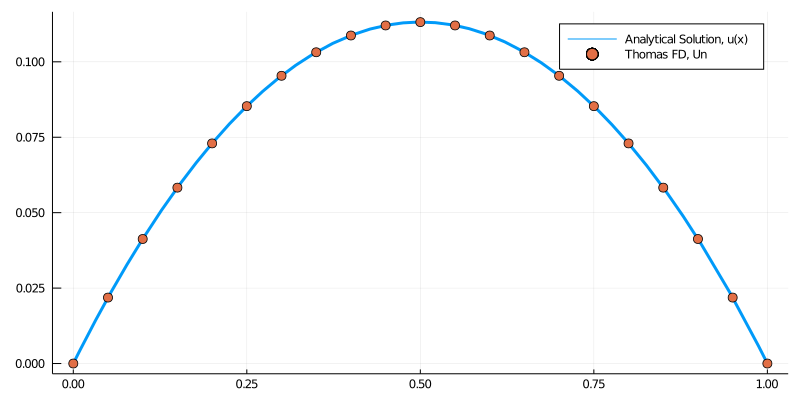

In [4]:
u(x) = 1 -  (exp(x) + exp(1-x)) / (1 + MathConstants.e)
plot(u, 0, 1, lw=3, label = "Analytical Solution, u(x)", size = (800, 400))

N = 20
h = 1/N
xn = 0:h:1
fn = ones(N-1)
Un = zeros(N+1)

d = ones(N-1) .* (2 / h^2 + 1)
du = ones(N-2) .* (-1 / h^2)
dl = ones(N-2) .* (-1 / h^2)
FD = Tridiagonal(dl, d, du)

Un[2:N] = thomas(FD, fn)
scatter!(xn, Un, ms=5, label = "Thomas FD, Un")

Sources

1. E. Süli and D. Mayer, An Introduction to Numerical Analysis. Chapters 2 & 3
2. https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
3. A. Pierce, Math 316: Lecture 8 notes, retrieved from https://www.math.ubc.ca/~peirce/
4. https://www.quantstart.com/articles/Tridiagonal-Matrix-Solver-via-Thomas-Algorithm/
5. https://en.wikipedia.org/wiki/Crank–Nicolson_method